# Comparaison des performances par rapport à un SVM de type classifieur

## Lecture des données, tokenization et BoW

Dans cette section vous devez lire les données (seulement les consensus).

Vous devez construire votre tokenizer (et de préférence le sauvegarder).

Vous devez transformer votre jeu de données (liste de tweets et labels) en liste de vecteurs BoW + liste d'indice des labels.

In [1]:
# Les imports sont préparé ici
# n'enlevez pas les % car il permettent le reload de modules ou l'affichage dans le notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import random
import pickle as pkl
import re
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

**Tache 1** 1pt.

Importez/réécrivez le code permettant de lire vos données et les transformer en BoW.

A la fin de cette cellule, vous devrez avoir trois variables d'instanciées :
- X : la liste des vecteurs BoW de vos tweets
- Y_one_hot : la liste des indices des labels de vos tweets (Y_one_hot[i] doit contenir le label de X[i])
- Y_one_hot : la liste des labels sous forme one_hot (c'est similaire à un BoW, vous prenez un vecteur de zeros et mettez un 1 à l'indice du label)

In [2]:
def read_corpus(path, consensus=False):
    f = open(path, 'r', encoding='UTF-8')
    lines = f.readlines()
    f.close()
    corpus = []
    for l in lines:
        sl = l.split()
        if len(sl) == 0:
            continue
        if consensus:
            m = re.match(r"[(](.*),(.*),(consensus)[)]", sl[0])
            if m is not None:
                corpus.append([sl[1:], sl[0]])
        else:
            corpus.append([sl[1:], sl[0]])
    return corpus



class WordTokenizer:
    def __init__(self, bos='BOS', eos='EOS', unk='UNK', pad='PAD'):

        self.pad = pad
        self.unk = unk
        self.bos = bos
        self.eos = eos

        self.word2id = {pad: 0,
                        unk: 1,
                        bos: 2,
                        eos: 3}

        self.id2word = {0: pad,
                        1: unk,
                        2: bos,
                        3: eos}

    def add_to_voc(self, sent):
        """
        :param sentence: string
        :return: None
        """
        for w in sent:
            if w not in self.word2id.keys():
                self.word2id[w] = len(self.id2word.keys())
                self.id2word[self.word2id[w]] = w

    def str_to_ids(self, sentence):
        sent = sentence.split()
        ret = []
        for w in sent:
            if w not in self.word2id.keys():
                ret.append(self.word2id[self.unk])
            else:
                ret.append(self.word2id[w])

        return ret

    def words_to_ids(self, sent):
        ret = []
        for w in sent:
            if w not in self.word2id.keys():
                ret.append(self.word2id[self.unk])
            else:
                ret.append(self.word2id[w])

        return ret

    def ids_to_words(self, ids):
        words = []
        for i in ids:
            words.append(self.id2word[i])
        return words


class CharTokenizer:
    def __init__(self, bos='<B>', eos='<E>', unk='<U>', pad='<P>'):

        self.pad = pad
        self.unk = unk
        self.bos = bos
        self.eos = eos

        self.char2id = {pad: 0,
                        unk: 1,
                        bos: 2,
                        eos: 3}

        self.id2char = {0: pad,
                        1: unk,
                        2: bos,
                        3: eos}

    def add_to_voc(self, sentence):
        """
        adds vocabulary (chars) found in sentence to the dictionaries
        :param sentence: string
        :return: None
        """
        for w in sentence:
            if w not in self.char2id.keys():
                self.char2id[w] = len(self.id2char.keys())
                self.id2char[self.char2id[w]] = w

    def chars_to_ids(self, sentence):
        ret = []
        for c in sentence:
            if c not in self.char2id.keys():
                ret.append(self.char2id[self.unk])
            else:
                ret.append(self.char2id[c])

        return ret

    def ids_to_chars(self, ids):
        chars = ""
        for i in ids:
            chars += self.id2char[i]
        return chars


class TrigramTokenizer:
    def __init__(self, bos='<B>', eos='<E>', unk='<U>', pad='<P>'):

        self.pad = pad
        self.unk = unk
        self.bos = bos
        self.eos = eos

        self.char2id = {pad: 0,
                        unk: 1,
                        bos: 2,
                        eos: 3}

        self.id2char = {0: pad,
                        1: unk,
                        2: bos,
                        3: eos}

    def add_to_voc(self, sentence):
        """
        adds vocabulary (chars) found in sentence to the dictionaries
        :param sentence: string
        :return: None
        """
        for i in range(len(sentence)-3):
            if sentence[i:i+3] not in self.char2id.keys():
                self.char2id[sentence[i:i+3]] = len(self.id2char.keys())
                self.id2char[self.char2id[sentence[i:i+3]]] = sentence[i:i+3]

    def chars_to_ids(self, sentence):
        ret = []
        for i in range(len(sentence)-3):
            if sentence[i:i+3] not in self.char2id.keys():
                ret.append(self.char2id[self.unk])
            else:
                ret.append(self.char2id[sentence[i:i+3]])

        return ret

    def ids_to_chars(self, ids):
        chars = ""
        for i in ids:
            chars += self.id2char[i]
        return chars

def list_to_bow(sent, dic):
    "sent list of ids, dic: dictionary {word, index}"
    vec = np.zeros(len(dic), dtype=int)
    for i in sent:
        vec[i] = 1
    return vec


def list_to_bow_freq(sent, dic):
    vec = np.zeros(len(dic))
    for i in sent:
        vec[i] += 1
    for i in range(len(vec)):
        vec[i] = vec[i] / len(sent)
    return vec


def n_grams(sents, n):

    new_sents = []
    dic = {}

    for s in sents:
        ns = []
        for i in range(len(s)-(n-1)):
            t = ""
            for j in range(n):
                t += f"{s[i+j]} "
            t = t[:-1]
            ns.append(t)
            if t not in dic:
                dic[t] = len(dic.keys())

        new_sents.append(ns)
    return new_sents, dic

In [3]:
# mettez votre code ici
# path = "C:/Users/Lucas/Downloads/train_label_final.txt"
path = "train_label_final.txt"

corpus = read_corpus(path, consensus=True)
tokenizer = WordTokenizer()

labels = {'pos': 0, 'neg': 1, 'neu': 2, 'irr': 3}
Y_one_hot = [] # Pour les labels il faut des vecteurs en one_hot, par exemple pour irr : [0,0,0,1]
Y = []
for i in range(len(corpus)):
    lab = re.match(r"[(].*,(.*),.*[)]", corpus[i][1])
    ap = np.zeros(len(labels.keys()))
    ap[labels[lab[1].lower()]] = 1
    Y.append(labels[lab[1].lower()])
    Y_one_hot.append(ap)


tweets = [c[0] for c in corpus]
for t in tweets:
    tokenizer.add_to_voc(t)

    
tweets_ids = [tokenizer.words_to_ids(t) for t in tweets]


X = [list_to_bow(tw, tokenizer.word2id) for tw in tweets_ids]
X_freq = [list_to_bow_freq(tw, tokenizer.word2id) for tw in tweets_ids]


print(X[0]) # x sont les tweets transformés en vecteurs BoW
print(len(X[0]))
print(X_freq[0])
print(len(X_freq[0]))
print(Y_one_hot[0]) # y sont les labels transformés en indice

[0 0 0 ... 0 0 0]
11762
[0. 0. 0. ... 0. 0. 0.]
11762
[1. 0. 0. 0.]


## Création du modèle

Nous allons d'abord créer une couche linéaire.
Celle ci comprendra le terme de biais.

Rappel de la formule de la couche linéaire: 
$$
\mathbf{a} = \mathbf{W}\mathbf{x}+ \mathbf{b}
$$

Notons *n_in* et *n_out* respectivement les dimensions de $\mathbf{x}$ et $\mathbf{y}$. 

**Tache 2** 1pt.
- Coder la fonction d'initialisation suivante, l'initialisation est aléatoire Gaussien centrée en 0 avec un écart type 1 / sqrt(n_in). La fonction retourne W et b. 


In [4]:
train_X = X[:1500]
train_Y = Y_one_hot[:1500]
train_Y_nhot = Y[:1500]

valid_X = X[1500:]
valid_Y = Y_one_hot[1500:]
valid_Y_nhot = Y[1500:]


## scikit-learn

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# On prend un kernel linéaire
kernel = 'linear'

linear_training_score = []
linear_valid_score = []
Cvalues = []

clf = SVC(kernel=kernel)

for C in [10**n for n in range(-5,6,1)]:
    Cvalues.append(C)
    clf.set_params(C=C)
    clf.fit(train_X, train_Y_nhot)
    
    pred_train_Y = clf.predict(train_X)
    pred_valid_Y = clf.predict(valid_X)
    
    trainscore = f1_score(train_Y_nhot, pred_train_Y, average='micro', labels=[i for i in range(4)])
    validscore = f1_score(valid_Y_nhot, pred_valid_Y, average='micro', labels=[i for i in range(4)])
    
    linear_training_score.append(trainscore)
    linear_valid_score.append(validscore)
    
    print("C=", C, "   training score:", trainscore, "   valid score:", validscore)
    

plt.title("F1 score en fonction de la valeur du paramètre C")
plt.semilogx(Cvalues, linear_training_score, label= "train score")
plt.plot(Cvalues, linear_valid_score, label= "valid score")
plt.xlabel("C")
plt.ylabel("scores")
plt.legend()
plt.show()

C= 1e-05    training score: 0.42733333333333334    valid score: 0.4176372712146423
C= 0.0001    training score: 0.42733333333333334    valid score: 0.4176372712146423


On fixe l'hyperparamètre C à 0.01 car au délà on a de l'overfitting

In [7]:
clf = SVC(kernel='linear')
clf.set_params(C=0.01)
clf.fit(train_X, train_Y_nhot)
pred_valid_Y = clf.predict(valid_X)

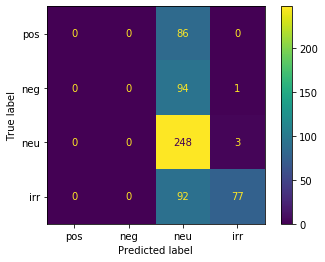

In [19]:
matrice = confusion_matrix(valid_Y_nhot, pred_valid_Y)

# df_cm = DataFrame(matrice, index = ['pos', 'neg', 'neu', 'irr'],
#                      columns = ['pos', 'neg', 'neu', 'irr'])
# plt.figure(figsize = (10,7))
# heatmap(df_cm, annot=True)
# plt.title("Confusion Matrix")
# plt.xlabel("predicted")
# plt.ylabel("actual")
# plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=matrice, display_labels=labels.keys())
disp.plot()